In [ ]:
import pytest
pytest.importorskip('waLBerla')

In [1]:
from pystencils.session import *
from time import perf_counter
from statistics import median
from functools import partial

## Benchmark for Python call overhead

In [2]:
inner_repeats = 100
outer_repeats = 5
sizes = [2**i for i in range(1, 8)]
sizes

In [3]:
def benchmark_pure(domain_size, extract_first=False):
    src = np.zeros(domain_size)
    dst = np.zeros_like(src)
    f_src, f_dst = ps.fields("src, dst", src=src, dst=dst)
    kernel = ps.create_kernel(ps.Assignment(f_dst.center, f_src.center)).compile()
    if extract_first:
        kernel = kernel.kernel
        start = perf_counter()
        for i in range(inner_repeats):
            kernel(src=src, dst=dst)
            src, dst = dst, src
        end = perf_counter()
    else:
        start = perf_counter()
        for i in range(inner_repeats):
            kernel(src=src, dst=dst)
            src, dst = dst, src
        end = perf_counter()
    return (end - start) / inner_repeats

def benchmark_datahandling(domain_size, parallel=False):
    dh = ps.create_data_handling(domain_size, parallel=parallel)
    f_src = dh.add_array('src')
    f_dst = dh.add_array('dst')
    kernel = ps.create_kernel(ps.Assignment(f_dst.center, f_src.center)).compile()
    start = perf_counter()
    for i in range(inner_repeats):
        dh.run_kernel(kernel)
        dh.swap('src', 'dst')
    end = perf_counter()
    return (end - start) / inner_repeats
   
    
name_to_func = {
    'pure_extract': partial(benchmark_pure, extract_first=True),
    'pure_no_extract': partial(benchmark_pure, extract_first=False),
    'dh_serial': partial(benchmark_datahandling, parallel=False),
    'dh_parallel': partial(benchmark_datahandling, parallel=True),
}

In [4]:
result = {'block_size': [],
          'name': [],
          'time': []}

for bs in sizes:
    print("Computing size ", bs)
    for name, func in name_to_func.items():
        for i in range(outer_repeats):
            time = func((bs, bs))
            result['block_size'].append(bs)
            result['name'].append(name)
            result['time'].append(time)

Computing size  2
Computing size  4
Computing size  8
Computing size  16
Computing size  32
Computing size  64
Computing size  128


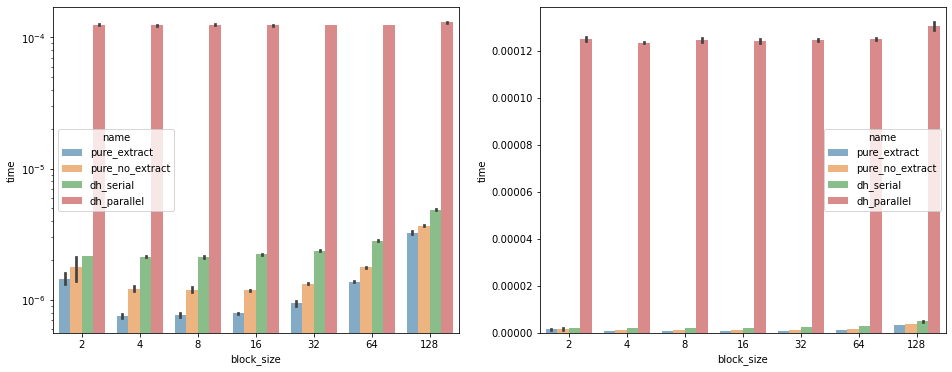

In [5]:
if 'is_test_run' not in globals():
    import pandas as pd
    import seaborn as sns
    
    data = pd.DataFrame.from_dict(result)

    plt.subplot(1,2,1)
    sns.barplot(x='block_size', y='time', hue='name', data=data, alpha=0.6)
    plt.yscale('log')

    plt.subplot(1,2,2)
    data = pd.DataFrame.from_dict(result)
    sns.barplot(x='block_size', y='time', hue='name', data=data, alpha=0.6)